The purpose of this project is to analyze the financial market data of Bajaj Finance and gain a comprehensive understanding of financial modeling and option pricing. The project involves downloading and preprocessing historical stock price data for Bajaj Finance, computing log-returns, and evaluating their statistical properties, such as normality and independence. It includes estimating historical volatility using log-returns and exploring advanced volatility estimation methods, such as GARCH models, to enhance accuracy.

Additionally, the project focuses on calculating the prices of European call and put options for Bajaj Finance using theoretical models like "Black-Scholes" and "Cox-Ross-Rubinstein (CRR)", while comparing the results obtained from different pricing methods.

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 13.5 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, jarque_bera, kstest, norm, probplot
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from math import exp, sqrt, log
from scipy.stats import norm
import scipy.stats as stats
from arch import arch_model

In [ ]:
# Download historical data for INFY.NS
data = yf.download("BAJFINANCE.NS", period="max")

# Save data to a CSV file
data.to_csv("BAJFINANCE.NS_historical_data.csv")

[*********************100%***********************]  1 of 1 completed


In [ ]:
drive.mount('/content/drive')

data_bajajfin = pd.read_csv("/content/drive/MyDrive/BAJFINANCE.NS_historical_data.csv")
data_bajajfin.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS,BAJFINANCE.NS
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-07-01 00:00:00+00:00,3.950042963027954,5.412679195404053,5.540926933288574,5.239737033843994,5.239737033843994,21923
3,2002-07-02 00:00:00+00:00,3.9727301597595215,5.4437689781188965,5.537041187286377,5.421422958374023,5.523438930511475,61044
4,2002-07-03 00:00:00+00:00,3.9890401363372803,5.466115951538086,5.545784950256348,5.328151226043701,5.505949974060059,34160


In [ ]:
df_bajajfin = data_bajajfin.iloc[2:, [0,2]]
df_bajajfin = df_bajajfin.reset_index()
df_bajajfin = df_bajajfin.drop(columns = ["index"])
df_bajajfin.head()

,Price,Close
0,2002-07-01 00:00:00+00:00,5.412679195404053
1,2002-07-02 00:00:00+00:00,5.4437689781188965
2,2002-07-03 00:00:00+00:00,5.466115951538086
3,2002-07-04 00:00:00+00:00,5.528296947479248
4,2002-07-05 00:00:00+00:00,5.59047794342041


### ***Data Pre-Processing:***

In [ ]:
df_bajajfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   5559 non-null   object
 1   Close   5559 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB


In [ ]:
df_bajajfin.rename(columns = {"Price": "Date"}, inplace = True)
df_bajajfin['Date'] = pd.to_datetime(df_bajajfin['Date']).dt.date
df_bajajfin['Date'] = pd.to_datetime(df_bajajfin['Date'])
df_bajajfin['Close'] = pd.to_numeric(df_bajajfin['Close'])

# This is our final dataset:
df_bajajfin.head()

,Date,Close
0,2002-07-01,5.412679
1,2002-07-02,5.443769
2,2002-07-03,5.466116
3,2002-07-04,5.528297
4,2002-07-05,5.590478


In [ ]:
df_bajajfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5559 non-null   datetime64[ns]
 1   Close   5559 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 87.0 KB


In [ ]:
df_bajajfin.isnull().sum()

,0
Date,0
Close,0


### 2. Plotting the prices for the given data.

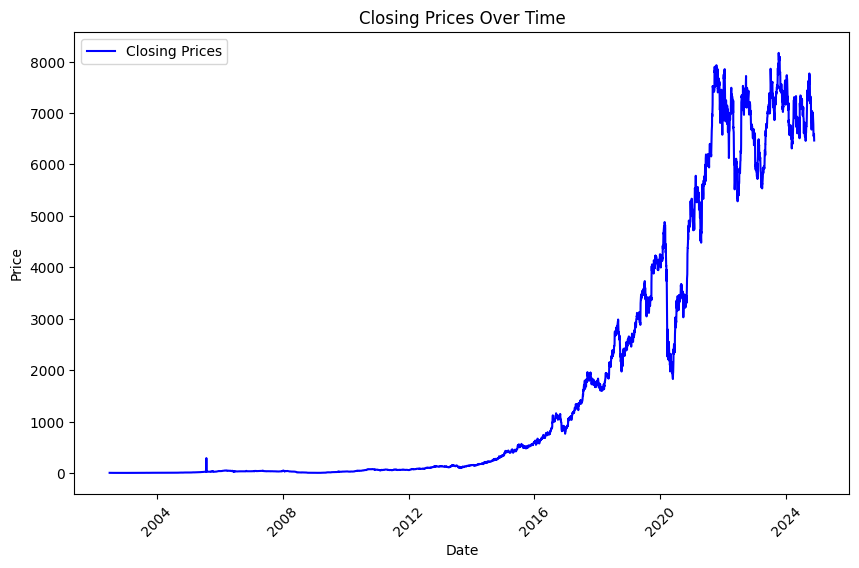

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(df_bajajfin['Date'], df_bajajfin['Close'], label = 'Closing Prices', color = 'blue')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### 3. Plotting log-returns for the given data.

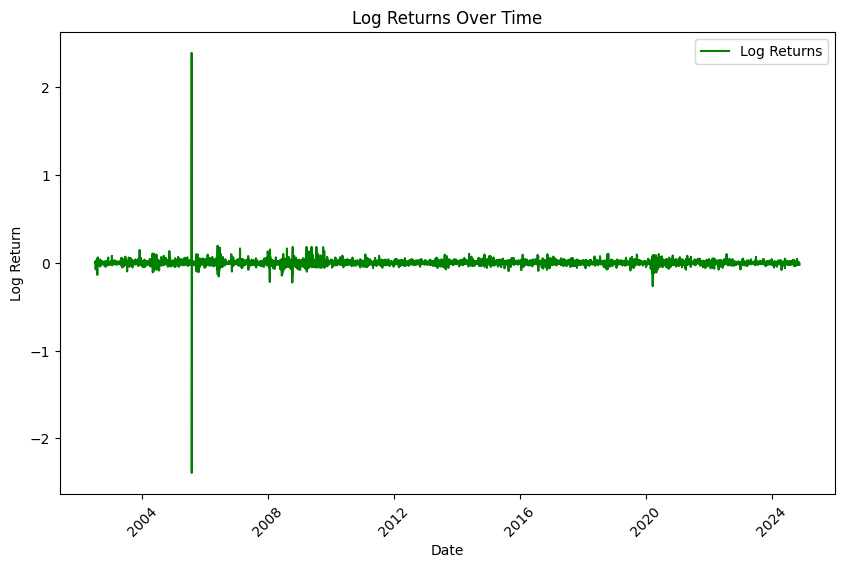

In [ ]:
# Calculating log-returns
df_bajajfin['Log_Returns'] = np.log(df_bajajfin['Close'] / df_bajajfin['Close'].shift(1))

plt.figure(figsize=(10, 6))
plt.plot(df_bajajfin['Date'][1:], df_bajajfin['Log_Returns'][1:], label = 'Log Returns', color = 'green')
plt.title('Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### 4. Checking the distribution of log-returns using QQ plot, histogram and other statistical test likeJerq-Berra, Kolmogorov-Smirnov test

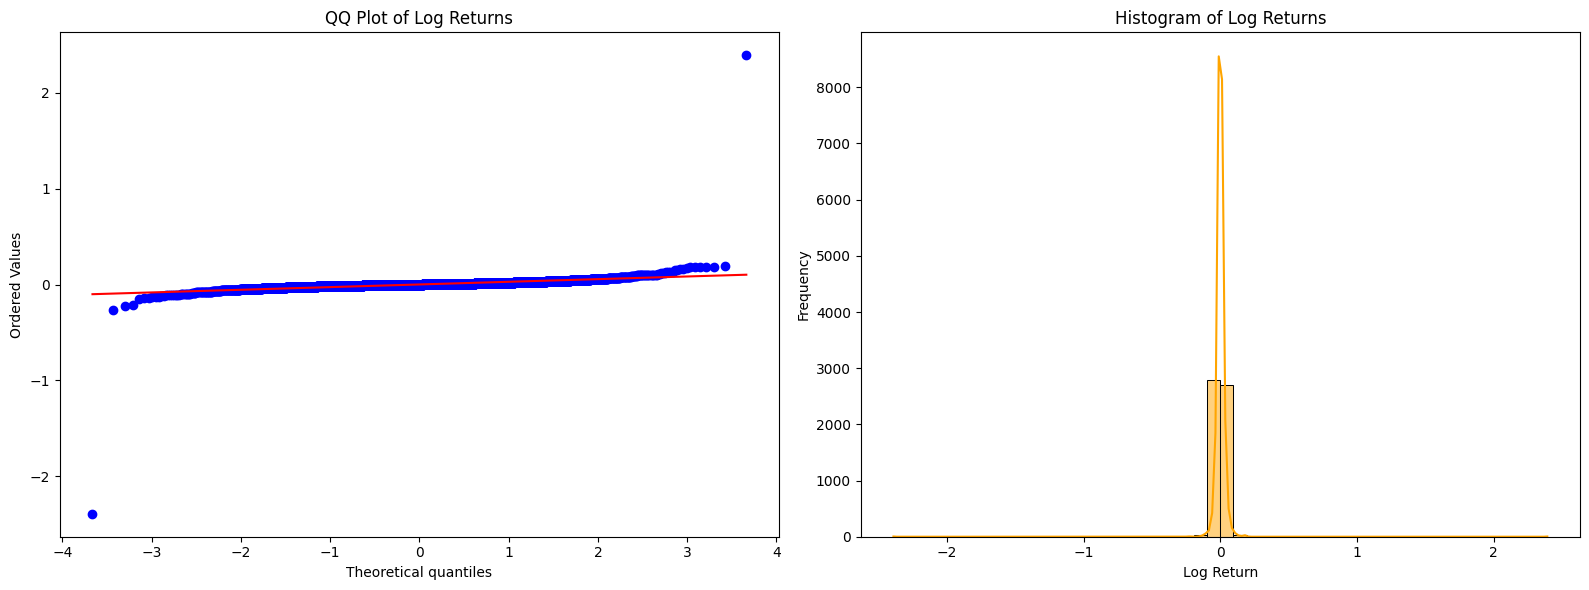

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# QQ Plot
stats.probplot(df_bajajfin['Log_Returns'].dropna(), dist = "norm", plot = axes[0])
axes[0].set_title('QQ Plot of Log Returns')

# Histogram
sns.histplot(df_bajajfin['Log_Returns'].dropna(), kde = True, bins = 50, color = 'orange', ax = axes[1])
axes[1].set_title('Histogram of Log Returns')
axes[1].set_xlabel('Log Return')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Statistical Tests:

jb_stat, jb_p = stats.jarque_bera(df_bajajfin['Log_Returns'].dropna())
print(f"Jarque-Bera Test: Statistic={jb_stat}, p-value={jb_p}")

ks_stat, ks_p = stats.kstest(df_bajajfin['Log_Returns'].dropna(), 'norm')
print(f"Kolmogorov-Smirnov Test: Statistic={ks_stat}, p-value={ks_p}")

Jarque-Bera Test: Statistic=566780971.8866854, p-value=0.0
Kolmogorov-Smirnov Test: Statistic=0.46258540690948724, p-value=0.0


### 5. Estimation of historical volatility Using Log Returns

In [ ]:
daily_volatility = df_bajajfin['Log_Returns'].std()

annualized_volatility = daily_volatility * np.sqrt(252)
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")

Annualized Volatility: 83.16%


In [ ]:
# On an average the 3-month risk-free rate in the Indian market is 6.5%
risk_free_rate = 0.065
print(f"Risk-Free Rate: {risk_free_rate * 100:.2f}%")

Risk-Free Rate: 6.50%


### 6. Checking if Log-Returns are Independent/Uncorrelated

<Figure size 1000x600 with 0 Axes>

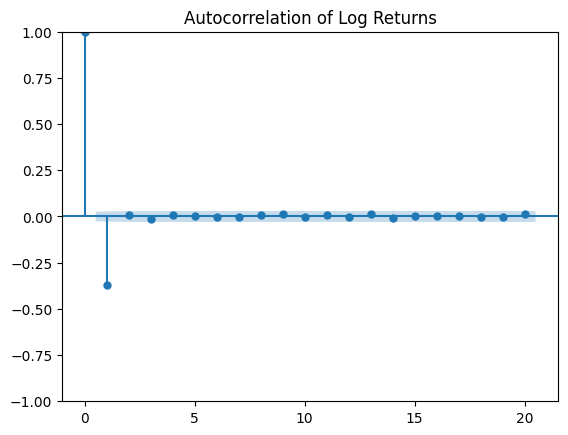

In [ ]:
plt.figure(figsize=(10, 6))
plot_acf(df_bajajfin['Log_Returns'].dropna(), lags=20)
plt.title('Autocorrelation of Log Returns')
plt.show()

## 7. Estimating the option price for an In-The-Money (ITM) European call option and In-The-Money European put option for the maturity November 15, 2024. Here I am using the "CRR" and "Black-Scholes" Models to compute the option prices.

In [ ]:
# Black Scholes:

def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [ ]:
S = df_bajajfin['Close'].iloc[-1]
K = S * 0.9
maturity_date = pd.Timestamp('2024-11-15')
pricing_date = pd.Timestamp('2024-11-02')
T = (maturity_date - pricing_date).days / 365
sigma = annualized_volatility
r = risk_free_rate

call_price = black_scholes(S, K, T, r, sigma, option_type = 'call')
print(f"In-the-Money Call Option Price: {call_price:.2f}")

put_price = black_scholes(S, K, T, r, sigma, option_type = 'put')
print(f"In-the-Money Put Option Price: {put_price:.2f}")

In-the-Money Call Option Price: 800.44
In-the-Money Put Option Price: 140.42


In [ ]:
# CRR Model

def crr_binomial(S, K, T, r, sigma, steps, option_type='call'):
    dt = T / steps
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    p = (exp(r * dt) - d) / (u - d)

    # Price tree
    price_tree = [S * (u**j) * (d**(steps - j)) for j in range(steps + 1)]

    # Option value at maturity
    if option_type == 'call':
        option_tree = [max(0, price - K) for price in price_tree]
    elif option_type == 'put':
        option_tree = [max(0, K - price) for price in price_tree]

    # Backward induction
    for i in range(steps - 1, -1, -1):
        option_tree = [
            exp(-r * dt) * (p * option_tree[j + 1] + (1 - p) * option_tree[j])
            for j in range(i + 1)
        ]
    return option_tree[0]

In [ ]:
steps = 100
crr_call_price = crr_binomial(S, K, T, r, sigma, steps, option_type='call')
print(f"CRR Call Option Price: {crr_call_price:.2f}")

crr_put_price = crr_binomial(S, K, T, r, sigma, steps, option_type='put')
print(f"CRR Put Option Price: {crr_put_price:.2f}")

CRR Call Option Price: 800.95
CRR Put Option Price: 140.93


## 10. Other Volatility Estimation Method (GARCH Model)

In [ ]:
# GARCH(1, 1) model
model = arch_model(df_bajajfin['Log_Returns'].dropna(), vol = 'Garch', p = 1, q = 1)
model_garch = model.fit(disp = "off")

print(model_garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9798.04
Distribution:                  Normal   AIC:                          -19588.1
Method:            Maximum Likelihood   BIC:                          -19561.6
                                        No. Observations:                 5558
Date:                Thu, Nov 21 2024   Df Residuals:                     5557
Time:                        14:02:13   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.0572e-03  7.220e-04      4.234  2.291e-05 [1.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002744. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


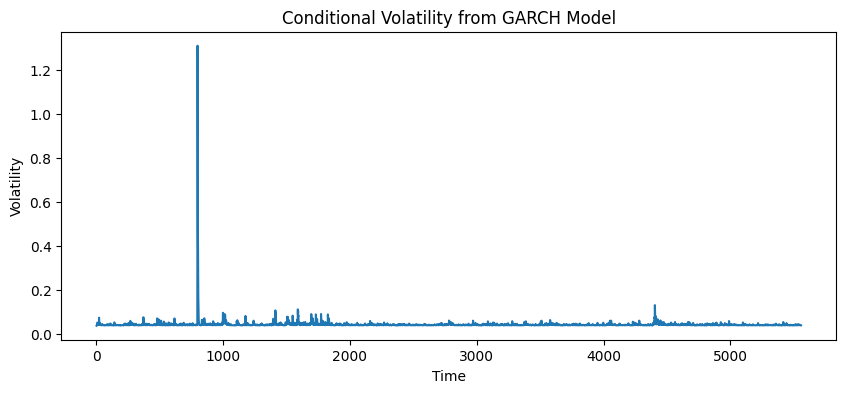

In [ ]:
conditional_volatility = model_garch.conditional_volatility

plt.figure(figsize=(10, 4))
plt.plot(conditional_volatility)
plt.title("Conditional Volatility from GARCH Model")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.show()